**Can you predict local epidemics of dengue fever?**

Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.

Because it is carried by mosquitoes, the transmission dynamics of dengue are related to climate variables such as temperature and precipitation. Although the relationship to climate is complex, a growing number of scientists argue that climate change is likely to produce distributional shifts that will have significant public health implications worldwide.

In recent years dengue fever has been spreading. Historically, the disease has been most prevalent in Southeast Asia and the Pacific islands. These days many of the nearly half billion cases per year are occurring in Latin America.

**Using environmental data collected by various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce—can you predict the number of dengue fever cases reported each week in San Juan, Puerto Rico and Iquitos, Peru?**

This is an intermediate-level practice competition. Your task is to predict the number of dengue cases each week (in each location) based on environmental variables describing changes in temperature, precipitation, vegetation, and more.

An understanding of the relationship between climate and dengue dynamics can improve research initiatives and resource allocation to help fight life-threatening pandemics.

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

**Import funtions, pull data, and preview**

In [128]:
#Data handling, model creation/evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.externals.six import StringIO
from scipy import stats
from datetime import date
from sklearn.externals.six import StringIO

#only show first 4 decimals for floats
np.set_printoptions(precision=4,suppress=True)

# visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz


In [129]:
#pull data
featuresData = pd.read_csv("dengue_features_train.csv")
labelsData = pd.read_csv("dengue_labels_train.csv")
diseaseData = pd.merge(featuresData, labelsData, on=['city', 'year', 'weekofyear'])
labelsData.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [130]:
#Preview the data
print(diseaseData.shape)
diseaseData.head()

(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [131]:
#Look at all of the data feature types. Confirm I don't need to change featurn names or types.
diseaseData.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

In [132]:
diseaseData.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


**Handle the datetime format, the city categorical feature, deal with missing values and reorder columns for use in models**

In [133]:
#format the week start date into a datetime
diseaseData['FormattedTimestamp'] = pd.to_datetime(diseaseData['week_start_date'].apply(str))
diseaseData.drop("week_start_date", inplace=True, axis=1)

In [134]:
#Handle categorical feature, city
city_dummies = pd.get_dummies(diseaseData.city).astype(int)
city_dummies = city_dummies[["iq"]]
city_dummies.head()
diseaseData = pd.concat([diseaseData,city_dummies],axis=1)
diseaseData.drop("city",inplace=True,axis=1)

In [135]:
#reorder the columns
cols = diseaseData.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
diseaseData = diseaseData[cols]
diseaseData.dtypes

FormattedTimestamp                       datetime64[ns]
iq                                                int64
year                                              int64
weekofyear                                        int64
ndvi_ne                                         float64
ndvi_nw                                         float64
ndvi_se                                         float64
ndvi_sw                                         float64
precipitation_amt_mm                            float64
reanalysis_air_temp_k                           float64
reanalysis_avg_temp_k                           float64
reanalysis_dew_point_temp_k                     float64
reanalysis_max_air_temp_k                       float64
reanalysis_min_air_temp_k                       float64
reanalysis_precip_amt_kg_per_m2                 float64
reanalysis_relative_humidity_percent            float64
reanalysis_sat_precip_amt_mm                    float64
reanalysis_specific_humidity_g_per_kg           

In [139]:
# check for number of missing values per column
# with removing null data, we lose 18% of data, so imputing makes sense into fillDiseaseData
diseaseData.isnull().sum()
print(diseaseData.shape)
diseaseDataNan = diseaseData.dropna()
print(diseaseDataNan.shape)
mean_per_column = diseaseData[diseaseData.columns.tolist()[1:-1]].apply(lambda x: x.mean(),axis=0)
fillDiseaseData = diseaseData[diseaseData.columns.tolist()[1:-1]].fillna(mean_per_column,axis=0)

(1456, 25)
(1199, 25)


**Create visualizations to preview data**

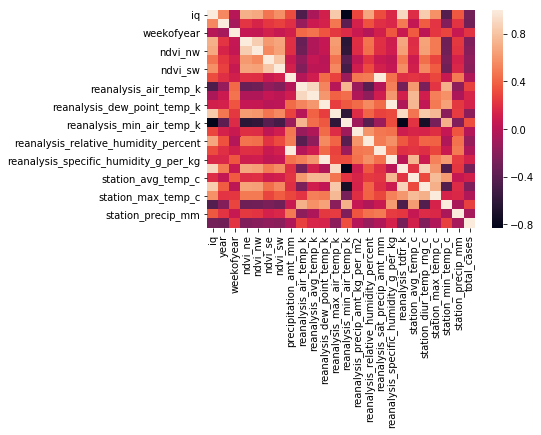

In [140]:
#correlation heatmap
sns.heatmap(diseaseData.corr())
#diseaseData.corr()

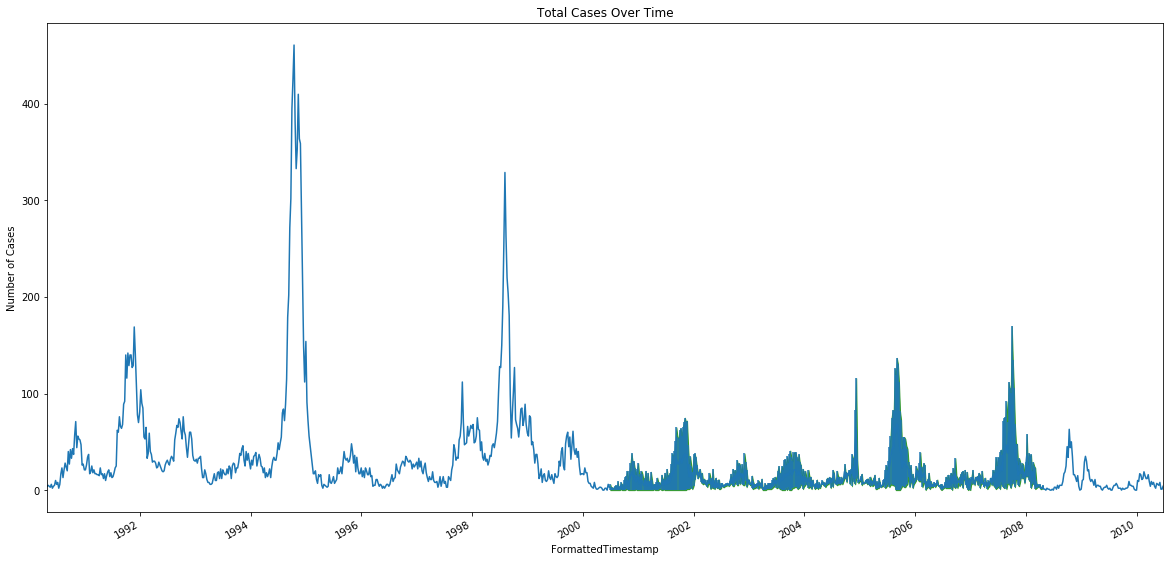

In [141]:
#quick visualization
diseaseGroups = diseaseData.groupby("FormattedTimestamp")
diseaseMeans = diseaseGroups["total_cases"].agg(np.mean)
diseaseErrs = diseaseGroups["total_cases"].agg(stats.sem)
diseaseMeans.plot(yerr=diseaseErrs,title="Total Cases Over Time",figsize=(20,10))
sns.mpl.pyplot.fill_between(x=diseaseMeans.index, y1=diseaseMeans-diseaseErrs, y2=diseaseMeans+diseaseErrs, color='g', alpha=0.7)
sns.mpl.pyplot.ylabel("Number of Cases")

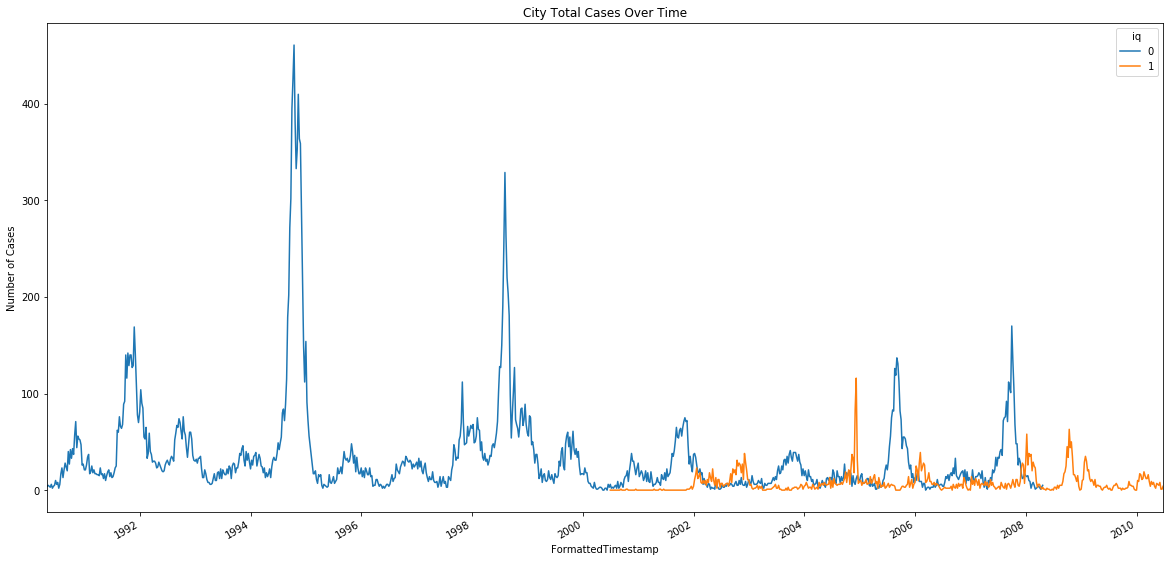

In [142]:
#visualize cases by city
cityDiseaseGroups = diseaseData.groupby(["FormattedTimestamp","iq"])
cityDiseaseMeans = cityDiseaseGroups["total_cases"].agg(np.mean)
cityDiseaseErrs = cityDiseaseGroups["total_cases"].agg(stats.sem)
unstackedCityMeans = cityDiseaseMeans.unstack(level=1)
unstackedCityErrs = cityDiseaseErrs.unstack(level=1)
unstackedCityMeans.plot(yerr=unstackedCityErrs,title="City Total Cases Over Time",figsize=(20,10))
sns.mpl.pyplot.ylabel("Number of Cases")

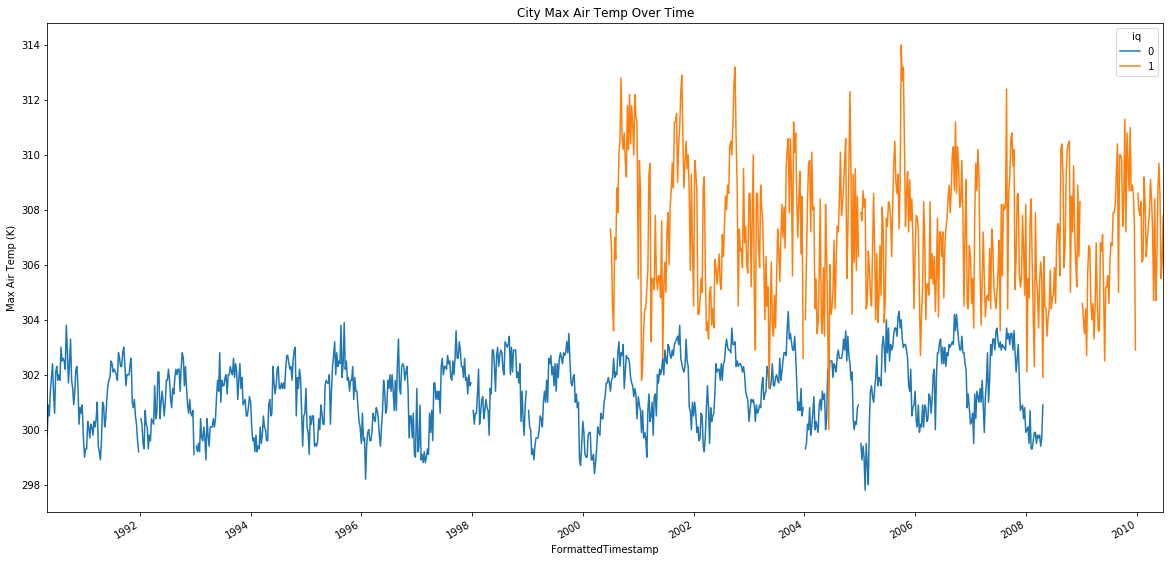

In [13]:
#visualize temperature by city
cityDiseaseGroups = diseaseData.groupby(["FormattedTimestamp","iq"])
cityDiseaseMeans = cityDiseaseGroups["reanalysis_max_air_temp_k"].agg(np.mean)
cityDiseaseErrs = cityDiseaseGroups["reanalysis_max_air_temp_k"].agg(stats.sem)
unstackedCityMeans = cityDiseaseMeans.unstack(level=1)
unstackedCityErrs = cityDiseaseErrs.unstack(level=1)
unstackedCityMeans.plot(yerr=unstackedCityErrs,title="City Max Air Temp Over Time",figsize=(20,10))
sns.mpl.pyplot.ylabel("Max Air Temp (K)")

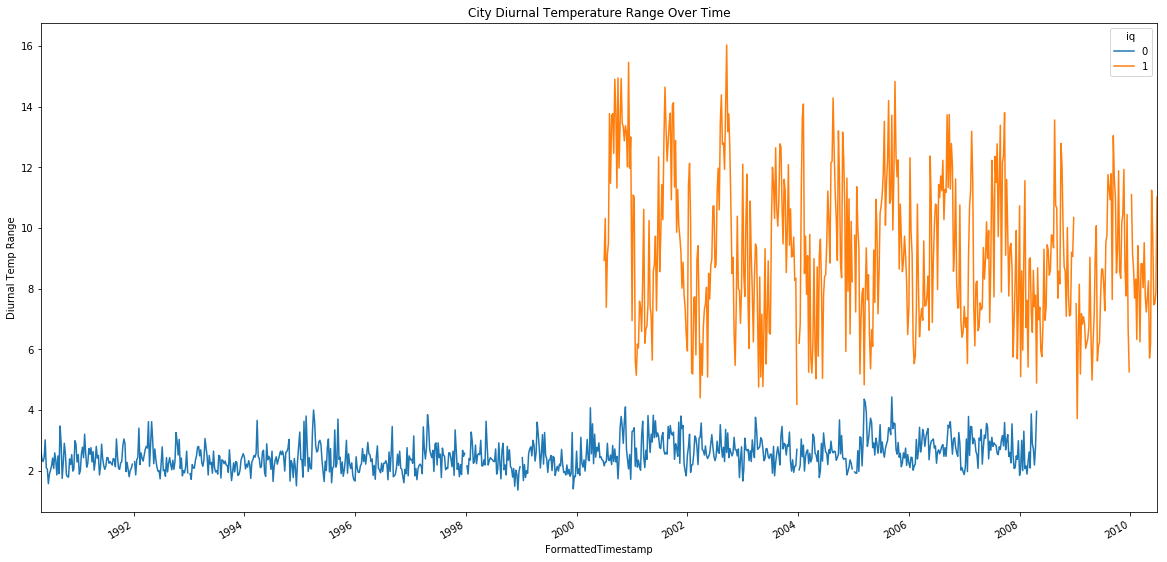

In [14]:
#visualize diurnal temperature range by city
cityDiseaseGroups = diseaseData.groupby(["FormattedTimestamp","iq"])
cityDiseaseMeans = cityDiseaseGroups["reanalysis_tdtr_k"].agg(np.mean)
cityDiseaseErrs = cityDiseaseGroups["reanalysis_tdtr_k"].agg(stats.sem)
unstackedCityMeans = cityDiseaseMeans.unstack(level=1)
unstackedCityErrs = cityDiseaseErrs.unstack(level=1)
unstackedCityMeans.plot(yerr=unstackedCityErrs,title="City Diurnal Temperature Range Over Time",figsize=(20,10))
sns.mpl.pyplot.ylabel("Diurnal Temp Range")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a0cd4c650>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a18fdda50>], dtype=object)

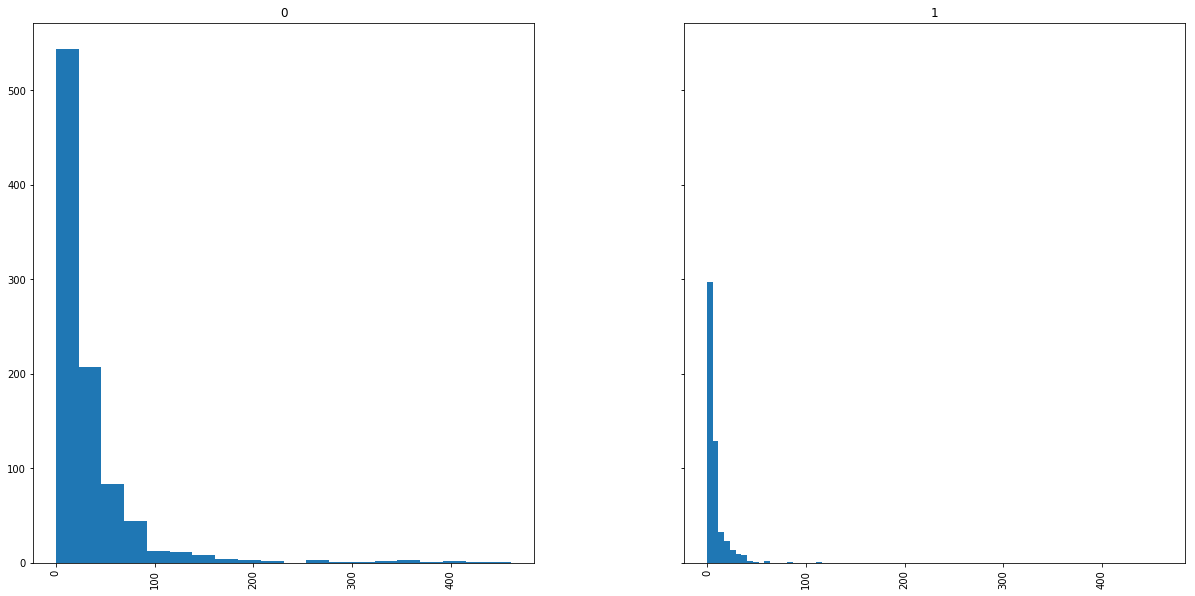

In [163]:
#histogram of cases if right skewed
diseaseData["total_cases"].hist(by=diseaseData["iq"],
                              bins=20,
                              sharex=True,
                              sharey=True,
                              figsize=(20,10))

**Start building models using all features**

('The y intercept:', 4973.4975787072017)
('The single coefficient:', array([-2.4731]))
('MAE:', 21.119002078659946)


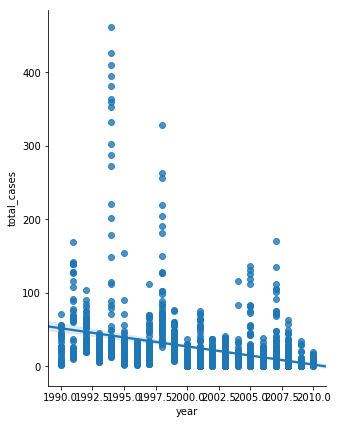

In [52]:
#create a linear regression with the one variable with the highest correlation, year
feature_col = ['year']
X = diseaseData[feature_col]
y = diseaseData.total_cases
cases_linreg = LinearRegression()
cases_linreg.fit(X, y)
print("The y intercept:", cases_linreg.intercept_)
print("The single coefficient:", cases_linreg.coef_)
print("MAE:", mean_absolute_error(y, cases_linreg.predict(X)))
sns.pairplot(diseaseData,x_vars=['year'],y_vars='total_cases',size=6, aspect=0.8,kind='reg')

In [143]:
#multiple linear regression without scaling
all_feature_cols = fillDiseaseData.columns.tolist()
all_X = fillDiseaseData[all_feature_cols]
all_y = diseaseData.total_cases
all_linreg = LinearRegression()
all_linreg.fit(all_X,all_y)
all_pred = all_linreg.predict(all_X)
print(list(zip(all_feature_cols, all_linreg.coef_)))
print(all_linreg.coef_)
print("The intercept is:", all_linreg.intercept_)
print("MAE:", mean_absolute_error(all_y,all_pred))
all_feature_coef = zip(all_feature_cols, all_linreg.coef_)
#make a list of the features that have higher coefficients/impact on number of cases
important_features =[]
for i in all_feature_coef:
    #current = all_feature_coef[i]
    if abs(i[1]) > .3:
        important_features.append(i[0])

[('iq', -1.4723598164374827), ('year', -1.7325612808455926), ('weekofyear', 0.42591892894898065), ('ndvi_ne', -0.38007671118680675), ('ndvi_nw', 1.9237182408164843), ('ndvi_se', -19.247406329716473), ('ndvi_sw', 26.746663165624071), ('precipitation_amt_mm', -0.013013581196635204), ('reanalysis_air_temp_k', 5.8355403953166389), ('reanalysis_avg_temp_k', -6.5134690273314089), ('reanalysis_dew_point_temp_k', -17.46744604391769), ('reanalysis_max_air_temp_k', 0.39434513824559581), ('reanalysis_min_air_temp_k', -0.2777397435321296), ('reanalysis_precip_amt_kg_per_m2', -0.0015498063275405372), ('reanalysis_relative_humidity_percent', -0.65175916319928362), ('reanalysis_sat_precip_amt_mm', -0.013013581195899349), ('reanalysis_specific_humidity_g_per_kg', 23.074994888017244), ('reanalysis_tdtr_k', -1.6071962041796688), ('station_avg_temp_c', -2.0850442077894926), ('station_diur_temp_rng_c', -1.6684909464455977), ('station_max_temp_c', 2.5238728197938087), ('station_min_temp_c', -0.225639191034

In [144]:
#multiple linear regression with scaling
scaler = StandardScaler()
scaler.fit(all_X)
all_X_scaled = scaler.transform(all_X)
#print("origial values:",all_X.values)
#print("scaled values:",all_X_scaled)
# figure out how the standardization worked
#print("Mean of each column:",scaler.mean_)
#print("standard deviation of each column:",scaler.scale_)
#print("Z-scoring the values by hand to make sure we arent crazy:",(all_X.values - scaler.mean_) / scaler.scale_)
#print("Final Means of scaled data, per column:",all_X_scaled.mean(axis=0))
#print("Final SD's of scaled data, per column:",all_X_scaled.std(axis=0))
all_linreg_scaled = LinearRegression()
all_linreg_scaled.fit(all_X_scaled,all_y)
all_pred_scaled = all_linreg_scaled.predict(all_X_scaled)
print(all_linreg_scaled.coef_)
print("The intercept is:", all_linreg_scaled.intercept_)
print("MAE:", mean_absolute_error(all_y,all_pred_scaled))
print("Does not need scaling, same MAE")

[ -0.7055  -9.367    6.3949  -0.0497   0.2266  -1.4103   2.2263  -0.5662
   7.9204  -8.187  -26.5859   1.2707  -0.7098  -0.0671  -4.645   -0.5662
  35.4583  -5.6783  -2.6536  -3.4974   4.9093  -0.3533   0.1944]
('The intercept is:', 24.675137362637642)
('MAE:', 20.211194321075336)
Does not need scaling, same MAE


In [19]:
#pairplot
#total_cases_bins = diseaseData
#total_cases_bins["bins"] = pd.cut(diseaseData["total_cases"],5)
#sns.pairplot(total_cases_bins, hue="bins", palette='coolwarm')

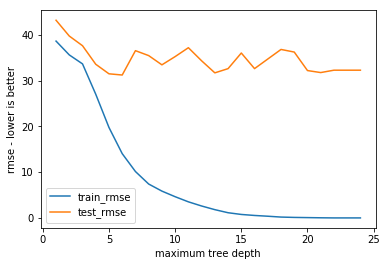

In [20]:
#decision tree test depth
all_X_train,all_X_test,all_y_train,all_y_test = train_test_split(all_X,all_y,test_size=.4,
                                                 random_state=1234)

depths = range(1,25)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(all_X_train,all_y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(all_y_train,decision_tree.predict(all_X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(all_y_test,decision_tree.predict(all_X_test)))
    #print("Decision Tree Train/Test RMSE:",depth,curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

In [58]:
#depth of 6 had the best performance. Looking at R^2 value to compare to other models
decision_tree = DecisionTreeRegressor(max_depth=6,random_state=10)
decision_tree.fit(all_X_train,all_y_train)
print("MAE:", mean_absolute_error(all_y_test,decision_tree.predict(all_X_test)))
#visualize the tree
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=all_X.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(graph.create_png())

('MAE:', 15.107781768354103)


In [69]:
#random forest
random_forest = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
random_forest.fit(all_X_train, all_y_train)
print("MAE:", mean_absolute_error(all_y_test,random_forest.predict(all_X_test)))

final_model = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
final_model.fit(all_X, all_y)

('MAE:', 14.588511149228129)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=True, random_state=12, verbose=0, warm_start=False)

In [93]:
#try a random forest only using important features identified in multiple linear regression
important_X = fillDiseaseData[important_features]
all_y = diseaseData.total_cases
imp_X_train,imp_X_test,all_y_train,all_y_test = train_test_split(important_X,all_y,test_size=.4,
                                                 random_state=1234)
random_forest_2 = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
random_forest_2.fit(imp_X_train, all_y_train)
print("MAE:", mean_absolute_error(all_y_test,random_forest_2.predict(imp_X_test)))

('MAE:', 13.581478559176672)


**What if we change the timeline?**

In [162]:
#pull data
weeks_shift = 1
featuresData = pd.read_csv("dengue_features_train.csv")
labelsData_shift = pd.read_csv("dengue_labels_train.csv")
#shift the week back one
labelsData_shift.columns = ['city', 'year', 'originalweek', 'total_cases']
labelsData_shift['weekofyear'] = labelsData_shift['originalweek']-weeks_shift
labelsData_shift.ix[labelsData_shift.weekofyear==0, ['year'] ] = labelsData_shift.ix[labelsData_shift.weekofyear==0, ['year'] ]-1
labelsData_shift.ix[labelsData_shift.weekofyear==0, ['weekofyear'] ] = 52
#print(labelsData_shift.head())
del labelsData_shift['originalweek']
diseaseData_shift = pd.merge(featuresData, labelsData_shift, on=['city', 'year', 'weekofyear'])
#print(diseaseData.head)
#print(diseaseData_shift.head)
#format the week start date into a datetime
diseaseData_shift['FormattedTimestamp'] = pd.to_datetime(diseaseData_shift['week_start_date'].apply(str))
diseaseData_shift.drop("week_start_date", inplace=True, axis=1)
#Handle categorical feature, city
city_dummies_shift = pd.get_dummies(diseaseData_shift.city).astype(int)
city_dummies_shift = city_dummies_shift[["iq"]]
diseaseData_shift = pd.concat([diseaseData_shift,city_dummies_shift],axis=1)
diseaseData_shift.drop("city",inplace=True,axis=1)
#reorder the columns
cols_shift = diseaseData_shift.columns.tolist()
cols_shift = cols_shift[-1:] + cols_shift[:-1]
cols_shift = cols_shift[-1:] + cols_shift[:-1]
diseaseData_shift = diseaseData_shift[cols]
# check for number of missing values per column
# with removing null data, we lose 18% of data, so imputing makes sense into fillDiseaseData
mean_per_column = diseaseData_shift[diseaseData_shift.columns.tolist()[1:-1]].apply(lambda x: x.mean(),axis=0)
fillDiseaseData_shift = diseaseData_shift[diseaseData_shift.columns.tolist()[1:-1]].fillna(mean_per_column,axis=0)

#run the random forest
all_feature_cols_shift = fillDiseaseData_shift.columns.tolist()
all_X_shift = fillDiseaseData_shift[all_feature_cols_shift]
all_y_shift = diseaseData_shift.total_cases
all_X_shift_train,all_X_shift_test,all_y_shift_train,all_y_shift_test = train_test_split(all_X_shift,all_y_shift,
                                                                                         test_size=.4,
                                                                                         random_state=1234)
random_forest_shift = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
random_forest_shift.fit(all_X_shift_train, all_y_shift_train)
print("MAE:", mean_absolute_error(all_y_shift_test,random_forest_shift.predict(all_X_shift_test)))

/Applications/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


('MAE:', 17.088093425605535)


**Give the prediction a shot!!**

In [70]:
#format the Test data so it can be used in the model
finalTestData = pd.read_csv("dengue_features_test.csv")
    #remove week start date
del finalTestData["week_start_date"]
    #change city data to int
city_dummies_test = pd.get_dummies(finalTestData.city).astype(int)
city_dummies_test = city_dummies_test[["iq"]]
finalTestData = pd.concat([finalTestData,city_dummies_test],axis=1)
finalTestData.drop("city",inplace=True,axis=1)
    #reorder columns
cols_test = finalTestData.columns.tolist()
cols_test = cols_test[-1:] + cols_test[:-1]
finalTestData = finalTestData[cols_test]
    #fill missing values
mean_per_column_test = finalTestData[finalTestData.columns.tolist()[0:]].apply(lambda x: x.mean(),axis=0)
fillFinalTestData = finalTestData[finalTestData.columns.tolist()[0:]].fillna(mean_per_column,axis=0)
#PREDICT
final_model.predict(fillFinalTestData)
finalTestData['total_cases'] = decision_tree.predict(fillFinalTestData)
submissionData = finalTestData
submissionData.total_cases.value_counts()
#del_cols = [3:-2]
#del submissionData[[3:-2]]
#THIS DOESNT WORKKKKKKKKK
#submissionData.drop(['ndvi_ne','ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'], axis=1, inplace=True)
#submissionData['city'] = for i in submissionData['iq']:
#    if i == 0
#submissionData.columns.tolist()

4.536797      141
10.883721      68
19.589744      60
13.128713      58
12.433333      53
28.142857       9
42.500000       7
82.000000       4
12.000000       4
23.500000       3
63.500000       3
66.500000       2
46.500000       1
62.000000       1
79.000000       1
106.000000      1
Name: total_cases, dtype: int64